## **1.1 $\texttt{SubEnv Synth}$ testing**

Experiments related to the $\texttt{SubEnv Synth}$.

In [1]:
#Git clone the ddsp_textures repo in the parent directory if you haven't already
import os
import subprocess

# Define the path where you want to clone the repository
repo_url = "https://github.com/cordutie/ddsp_textures.git"
clone_path = os.path.abspath(os.path.join('..', '..', 'ddsp_textures'))

# Check if the directory already exists
if not os.path.exists(clone_path):
    print(f"Cloning the repository to {clone_path}...")
    subprocess.run(["git", "clone", repo_url, clone_path])
    print("Repository cloned successfully.")
else:
    print(f"The repository already exists at {clone_path}.")

The repository already exists at /home/esteban/Desktop/ddsp_textures_thesis/ddsp_textures.


In [2]:
#Add the ddsp's parent directory to the Python path so that we can import the necessary modules
import sys

ddsp_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if ddsp_dir not in sys.path:
    sys.path.append(ddsp_dir)

In [3]:
# import modules
import ddsp_textures.signal_processors.synthesizers as sp
import ddsp_textures.auxiliar.seeds                 as seeds

# Extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch

In [4]:
# Computationnal functions ---------------------------------------------------------------------------------------

# Resysnthesis function
def resynthesize_segment(segment, sr, seed, N_filter_bank, param_per_env):
    segment = torch.tensor(segment, dtype=torch.float32)
    param_real, param_imag = sp.SubEnv_param_extractor(segment, sr, N_filter_bank, param_per_env)
    new_audio = sp.SubEnv(param_real, param_imag, seed)
    audio_resynth=new_audio.numpy()
    return audio_resynth

# Overlap and add function
def OLA(segments_resynthesis, frame_size, hop_size, window):
    N_segments = len(segments_resynthesis)
    audio_final = np.zeros(frame_size + (N_segments-1)*hop_size)
    for i in range(N_segments):
        synthesized_segment = segments_resynthesis[i]
        synthesized_segment = synthesized_segment * window
        audio_final[i * hop_size: i * hop_size + frame_size] += synthesized_segment
    audio_final = audio_final
    return audio_final

# Full resynthesis function
def resynthesis_full(audio, sr, seed, N_filter_bank, frame_size, param_per_env):
    hop_size = frame_size // 2
    # Make list of segments
    segments_og = []  
    for i in range(0, len(audio) - frame_size, hop_size):
        segments_og.append(audio[i:i + frame_size])
    # Resynthesize each segment using resynthesize function
    segments_resynthesis = []
    for i in range(len(segments_og)):
        segments_resynthesis.append(resynthesize_segment(segments_og[i], sr, seed, N_filter_bank, param_per_env))
    # Overlap and add the resynthesized segments using hann window and hop size
    audio_final = OLA(segments_resynthesis, frame_size, hop_size, np.hanning(frame_size))
    return audio_final

# Plotters ------------------------------------------------------------------------------------------------------

def plotter_resynth_experiment(audio_og, audio_resynth, sr, label):
    #play sound 1
    print(f"{label} original audio")
    display(Audio(data=audio_og, rate=sr))
    #play sound 2
    print(f"{label} resynthesized audio")
    display(Audio(data=audio_resynth, rate=sr))
    # Compute hop length as integer number nfft * overlap_ratio
    nfft = 2048
    hop_length = nfft // 4
    # Desired frequency ticks on the y-axis
    freq_ticks = [62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
    time_ticks = [1, 2, 3, 4]
    # Make plots of spectrogram of original and resynthesized audio side by side using a Hann window
    plt.figure(figsize=(15, 5))
    # Original Audio Spectrogram
    plt.subplot(1, 2, 1)
    Pxx, freqs, bins, im = plt.specgram(audio_og, NFFT=nfft, Fs=sr, noverlap=hop_length, window=np.hanning(nfft))
    plt.ylim(31.25, 16000)  # Cap the frequencies between 20 Hz and 10,000 Hz
    plt.yscale('log')  # Plot on a logarithmic scale
    plt.yticks(freq_ticks, labels=[str(f) for f in freq_ticks])  # Set custom frequency ticks
    plt.xticks(time_ticks, labels=[str(t) for t in time_ticks])  # Set custom time ticks
    plt.colorbar(im).set_label('Intensity [dB]')
    plt.title(f"{label} original audio")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    # Resynthesized Audio Spectrogram
    plt.subplot(1, 2, 2)
    Pxx, freqs, bins, im = plt.specgram(audio_resynth, NFFT=nfft, Fs=sr, noverlap=hop_length, window=np.hanning(nfft))
    plt.ylim(31.25, 16000)  # Cap the frequencies between 20 Hz and 10,000 Hz
    plt.yscale('log')  # Plot on a logarithmic scale
    plt.yticks(freq_ticks, labels=[str(f) for f in freq_ticks])  # Set custom frequency ticks
    plt.xticks(time_ticks, labels=[str(t) for t in time_ticks])  # Set custom time ticks
    plt.colorbar(im).set_label('Intensity [dB]')
    plt.title(f"{label} resynthesized audio")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    # Final plot
    plt.tight_layout()
    plt.show()
    
def plotter_seed_experiment(audio_1, audio_2, audio_3, sr, label):
    # Play sound 1
    print(f"{label} resynthesis with seed 1")
    display(Audio(data=audio_1, rate=sr))
    # Play sound 2
    print(f"{label} resynthesis with seed 2")
    display(Audio(data=audio_2, rate=sr))
    # Play sound 3
    print(f"{label} resynthesis with seed 1")
    display(Audio(data=audio_3, rate=sr))
    # Compute hop length as integer number nfft * overlap_ratio
    nfft = 2048
    hop_length = nfft // 4
    # Desired frequency ticks on the y-axis
    freq_ticks = [62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
    # Time ticks (adjust these as necessary for your data)
    time_ticks = [0, 1, 2, 3, 4]  # Example time ticks, adjust if needed
    # Create a figure with subplots for each audio sample
    plt.figure(figsize=(22.5, 5))
    # Spectrogram for the first audio sample
    plt.subplot(1, 3, 1)
    Pxx, freqs, bins, im = plt.specgram(audio_1, NFFT=nfft, Fs=sr, noverlap=hop_length, window=np.hanning(nfft))
    plt.ylim(31.25, 16000)  # Cap the frequencies between 31.25 Hz and 16,000 Hz
    plt.yscale('log')  # Plot on a logarithmic scale
    plt.yticks(freq_ticks, labels=[str(f) for f in freq_ticks])  # Set custom frequency ticks
    plt.xticks(np.linspace(0, len(audio_1)/sr, num=len(time_ticks)), labels=[str(t) for t in time_ticks])  # Adjust time ticks
    plt.colorbar(im).set_label('Intensity [dB]')
    plt.title(f"{label} resynthesis with seed 1")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    # Spectrogram for the second audio sample
    plt.subplot(1, 3, 2)
    Pxx, freqs, bins, im = plt.specgram(audio_2, NFFT=nfft, Fs=sr, noverlap=hop_length, window=np.hanning(nfft))
    plt.ylim(31.25, 16000)  # Cap the frequencies between 31.25 Hz and 16,000 Hz
    plt.yscale('log')  # Plot on a logarithmic scale
    plt.yticks(freq_ticks, labels=[str(f) for f in freq_ticks])  # Set custom frequency ticks
    plt.xticks(np.linspace(0, len(audio_2)/sr, num=len(time_ticks)), labels=[str(t) for t in time_ticks])  # Adjust time ticks
    plt.colorbar(im).set_label('Intensity [dB]')
    plt.title(f"{label} resynthesis with seed 2")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    # Spectrogram for the third audio sample
    plt.subplot(1, 3, 3)
    Pxx, freqs, bins, im = plt.specgram(audio_3, NFFT=nfft, Fs=sr, noverlap=hop_length, window=np.hanning(nfft))
    plt.ylim(31.25, 16000)  # Cap the frequencies between 31.25 Hz and 16,000 Hz
    plt.yscale('log')  # Plot on a logarithmic scale
    plt.yticks(freq_ticks, labels=[str(f) for f in freq_ticks])  # Set custom frequency ticks
    plt.xticks(np.linspace(0, len(audio_3)/sr, num=len(time_ticks)), labels=[str(t) for t in time_ticks])  # Adjust time ticks
    plt.colorbar(im).set_label('Intensity [dB]')
    plt.title(f"{label} resynthesis with seed 3")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    # Show the plot
    plt.tight_layout()
    plt.show()

# Actual experiments --------------------------------------------------------------------------------------------

def resynthesis_experiment(audio, sr, label, seed, N_filter_bank, frame_size, param_per_env):
    audio_resynth = resynthesis_full(audio, sr, seed, N_filter_bank, frame_size, param_per_env)
    plotter_resynth_experiment(audio, audio_resynth, sr, label)

def seed_experiment(audio, sr, label, seeds_list, N_filter_bank, frame_size, param_per_env):
    seed_1=seeds_list[0]
    seed_2=seeds_list[1]
    seed_3=seeds_list[2]
    audio_resynth_1 = resynthesis_full(audio, sr, seed_1, N_filter_bank, frame_size, param_per_env)
    audio_resynth_2 = resynthesis_full(audio, sr, seed_2, N_filter_bank, frame_size, param_per_env)
    audio_resynth_3 = resynthesis_full(audio, sr, seed_3, N_filter_bank, frame_size, param_per_env)
    plotter_seed_experiment(audio_resynth_1, audio_resynth_2, audio_resynth_3, sr, label)


### Experiment 1: Resynthesis Task - Fire sounds

Fire original audio


Fire resynthesized audio


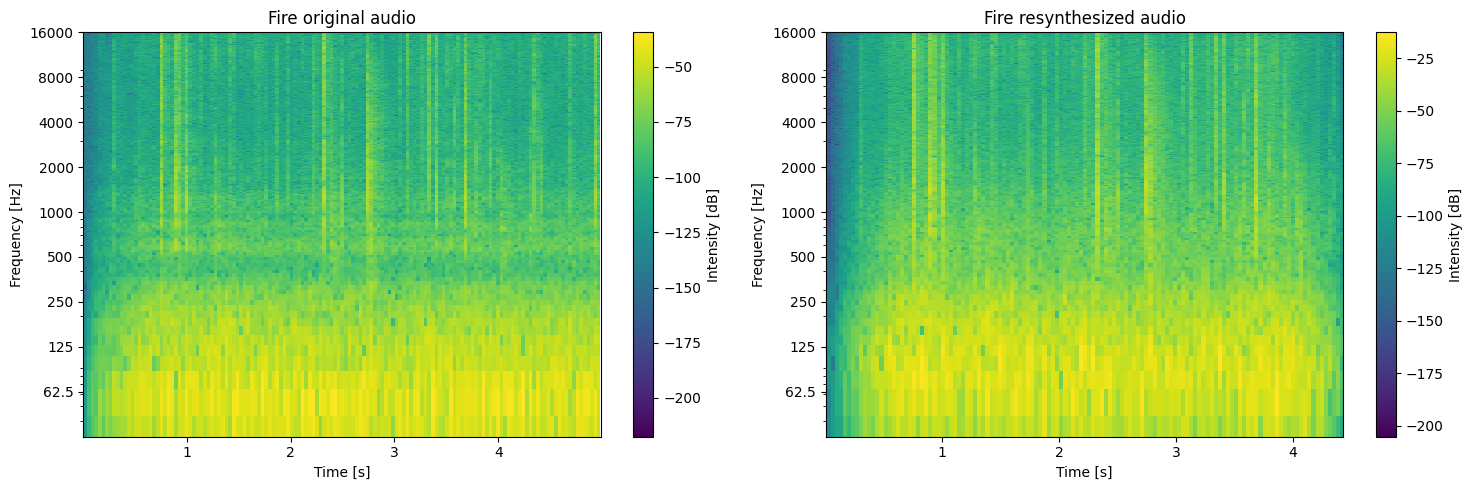

In [5]:
# FIRE RESYNTHESIS --------------------------------------

# Load audio to resynthesize ----------------------------
fire_path = "../data/sounds/fire.wav"
label = "Fire"
sr = 44100
fire_audio, _ = librosa.load(fire_path, sr=sr)
fire_audio = fire_audio[ : 5*sr] # Limit to 5 seconds

# Seed creation -----------------------------------------
N_filter_bank = 24 # This is a high number of filter (16 is the typical)
frame_size = 2**16 # around 1.48 seconds
seed = seeds.seed_maker(frame_size, 44100, N_filter_bank)

# Run the resynthesizer
param_per_env = 1024  # 1024*24 = 2**13 * 3 => compression of (2**13 * 3)/2**16 = 3/8 ~ 0.375 
resynthesis_experiment(fire_audio, sr, label, seed, N_filter_bank, frame_size, param_per_env)

### Experiment 2: Resynthesis Task - Water sounds

Water original audio


Water resynthesized audio


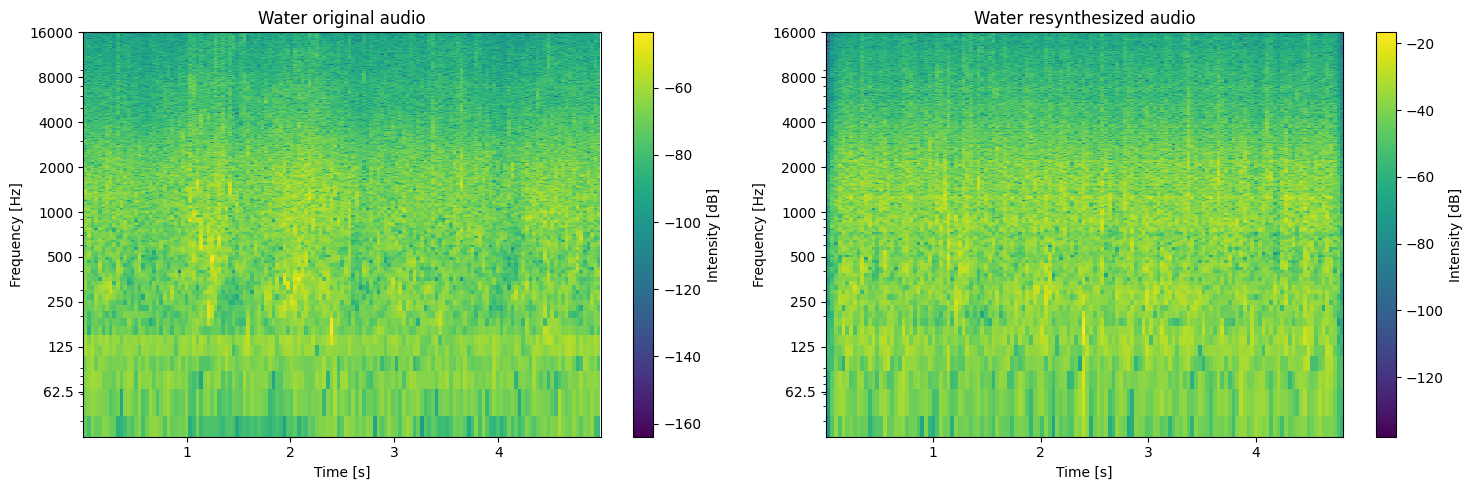

In [6]:
# WATER RESYNTHESIS --------------------------------------

# Load audio to resynthesize ----------------------------
water_path = "../data/sounds/water.wav"
label = "Water"
sr = 44100
water_audio, _ = librosa.load(water_path, sr=sr)
water_audio = water_audio[ : 5*sr] # Limit to 5 seconds

# Seed creation -----------------------------------------
N_filter_bank = 16
frame_size = 2**14 # around 0.38 seconds
seed = seeds.seed_maker(frame_size, 44100, N_filter_bank)

# Run the resynthesizer for a bunch of fire and water segments
param_per_env = 256  # 256*16 = 2**12 => compression of 2**12/2**14 = 1/4
resynthesis_experiment(water_audio, sr, label, seed, N_filter_bank, frame_size, param_per_env)

### Experiment 3: Seed exploration - fire sounds

Fire resynthesis with seed 1


Fire resynthesis with seed 2


Fire resynthesis with seed 1


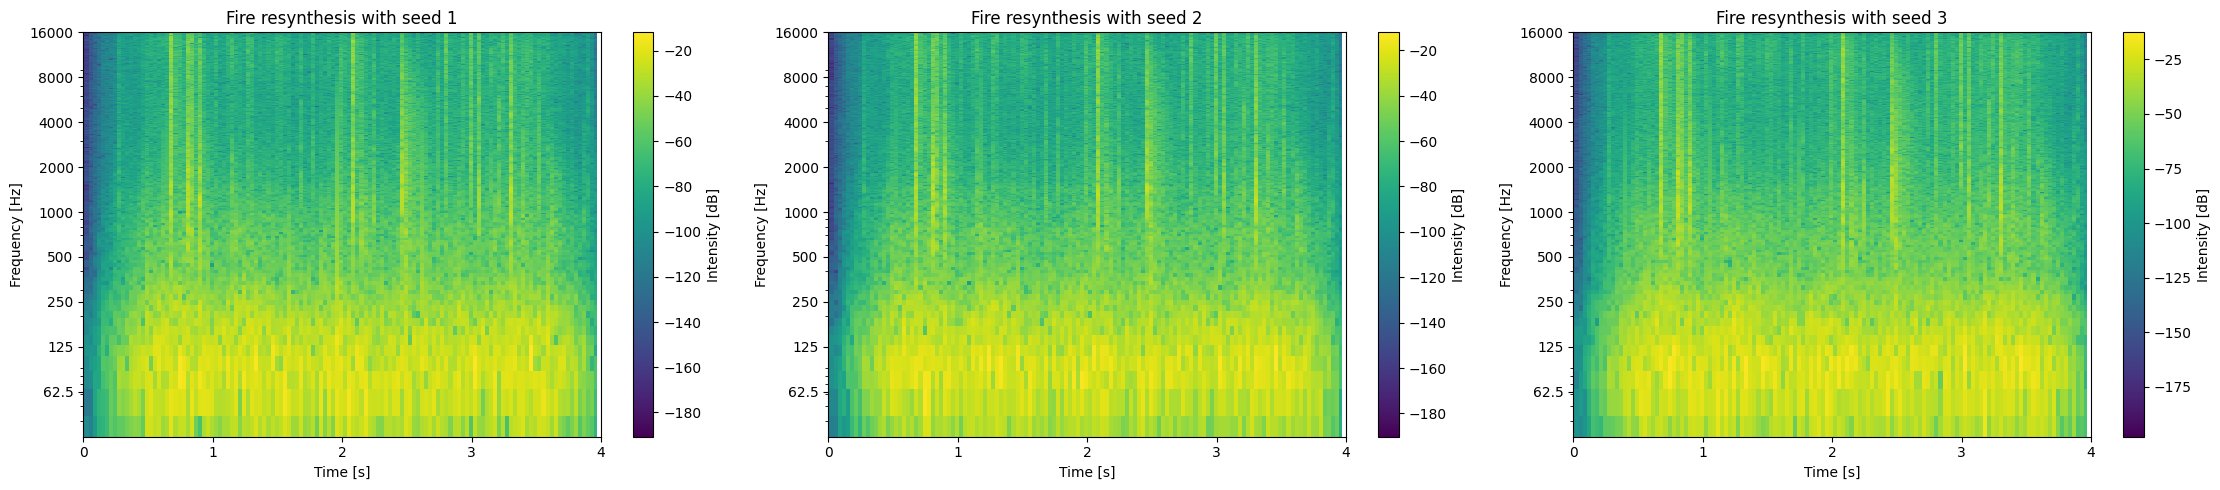

In [7]:
# Fire resynthesis with multiple seeds:

# Load audio to resynthesize ----------------------------
fire_path = "../data/sounds/fire.wav"
label = "Fire"
sr = 44100
fire_audio, _ = librosa.load(fire_path, sr=sr)
fire_audio = fire_audio[ : 5*sr] # Limit to 5 seconds

# Seed parameters ----------------------------------------
N_filter_bank = 24 # This is a high number of filter (16 is the typical)
frame_size = 2**16 # around 1.48 seconds
seeds_list = []
for i in range(3):
    seeds_list.append(seeds.seed_maker(frame_size, 44100, N_filter_bank))
    
# Run the resynthesizer
param_per_env = 1024  # 1024*24 = 2**13 * 3 => compression of (2**13 * 3)/2**16 = 3/8 ~ 0.375 
seed_experiment(fire_audio, sr, label, seeds_list, N_filter_bank, frame_size, param_per_env)

### Experiment 4: seed exploration - water sounds

Water resynthesis with seed 1


Water resynthesis with seed 2


Water resynthesis with seed 1


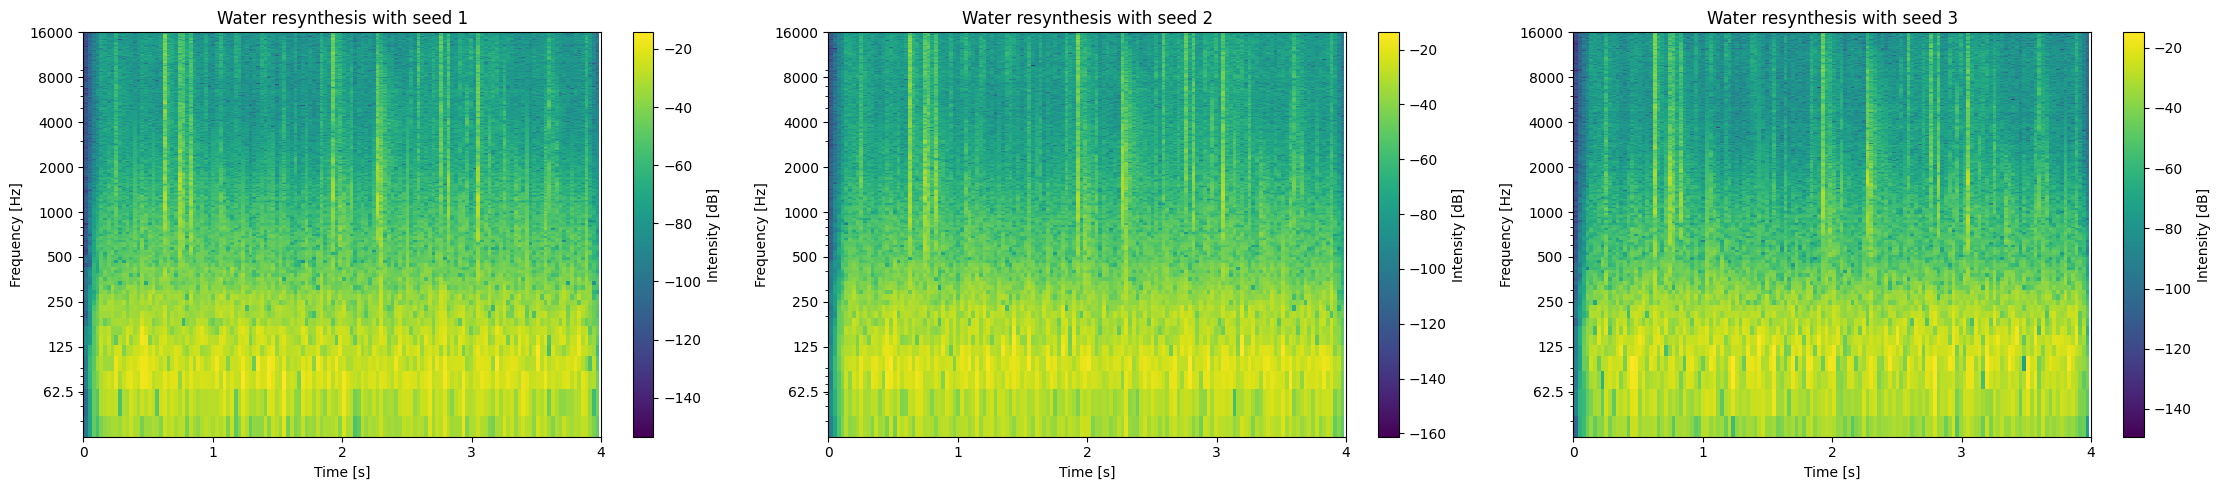

In [8]:
# Water resynthesis with multiple seeds:

# Load audio to resynthesize ----------------------------
water_path = "../data/sounds/water.wav"
label = "Water"
sr = 44100
water_audio, _ = librosa.load(water_path, sr=sr)
fire_audio = fire_audio[ : 5*sr] # Limit to 5 seconds

# Seed parameters ----------------------------------------
N_filter_bank = 16
frame_size = 2**14 # around 0.38 seconds
seeds_list = []
for i in range(3):
    seeds_list.append(seeds.seed_maker(frame_size, 44100, N_filter_bank))
    
# Run the resynthesizer
param_per_env = 256  # 1024*24 = 2**13 * 3 => compression of (2**13 * 3)/2**16 = 3/8 ~ 0.375 
seed_experiment(fire_audio, sr, label, seeds_list, N_filter_bank, frame_size, param_per_env)
